In [2]:
import numpy as np
import pandas as pd
import networkx as nx

from sklearn.cluster import KMeans
from sklearn import manifold

from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
orderdf = pd.read_csv('ignored_assets/orders.csv', parse_dates = [6,7])

In [4]:
coredf = orderdf[orderdf['dest_district_hash'].isin(orderdf['start_district_hash'].unique())]

In [5]:
dtable = pd.pivot_table(coredf, index=['start_district_hash'], 
                        columns=['dest_district_hash'], aggfunc=[np.mean],
                       values=['expected_travel_time'])

In [6]:
dtable.to_csv('travel_time.csv')

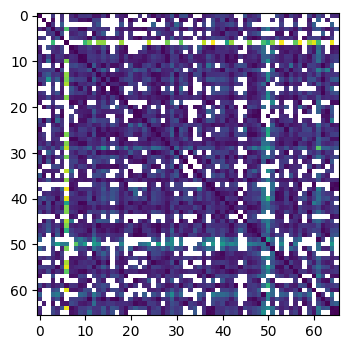

In [6]:
plt.imshow(dtable.as_matrix())

In [7]:
dtable

mean  \
                                             expected_travel_time   
dest_district_hash               08232402614a9b48895cc3d0aeb0e9f2   
start_district_hash                                                 
08232402614a9b48895cc3d0aeb0e9f2                         3.836914   
08f5b445ec6b29deba62e6fd8b0325a6                              NaN   
0a5fef95db34383403d11cb6af937309                              NaN   
1afd7afbc81ecc1b13886a569d869e8a                        28.241753   
1c60154546102e6525f68cb4f31e0657                              NaN   
1cbfbdd079ef93e74405c53fcfff8567                        33.491041   
1ecbb52d73c522f184a6fc53128b1ea1                              NaN   
2301bc920194c95cf0c7486e5675243c                        23.880362   
2350be163432e42270d2670cb3c02f80                        14.475147   
2407d482f0ffa22a947068f2551fe62c                        35.279205   
2920ece99323b4c111d6f9affc7ea034                        32.144838   
307afa4120c590b3a46cf4ff5415608a                        38.570531   
364bf755f9b270f0f9141d1a61de43ee                        38.586084   
38d5ad2d22b61109fd8e7b43cd0e8901                        15.235988   
3a43dcdff3c0b66b1acb1644ff055f9d                        40.281321   
3e12208dd0be281c92a6ab57d9a6fb32                         9.092131   
445ff793ebd3477d4a2e0b36b2db9271                              NaN   
44c097b7bd219d104050abbafe51bd49                        31.564070   
4725c39a5e5f4c188d382da3910b3f3f                        21.936880   
49ac89aa860c27e26c0836cb8dab2df2                        17.263423   
4b7f6f4e2bf237b6cc58f57142bea5c0                              NaN   
4b9e4cf2fbdc8281b8a1f9f12b80ce4d                              NaN   
4f4041f7db0c7f69892d9b74c1a7efa1                              NaN   
4f8d81b5c31af5d1ba579a65ddc8a5cb                        47.124480   
52a4e8aaa12f70020e889aed8fd5ddbc                        33.437247   
52d7b69796362a8ed1691a6cc02ddde4                         8.053516   
52e56004d92b8c74d53e1e42699cba6f                        25.708503   
58c7a4888306d8ff3a641d1c0feccbe3                        22.582424   
62afaf3288e236b389af9cfdc5206415                        28.601924   
693a21b16653871bbd455403da5412b4                        59.897080   
...                                                           ...   
82cc4851f9e4faa4e54309f8bb73fd7c                        21.261228   
8316146a6f78cc6d9f113f0390859417                              NaN   
87285a66236346350541b8815c5fae94                        33.964207   
8bb37d24db1ad665e706c2655d9c4c72                              NaN   
90c5a34f06ac86aee0fd70e2adce7d8a                        43.718453   
91690261186ae5bee8f83808ea1e4a01                        43.601808   
929ec6c160e6f52c20a4217c7978f681                        29.050683   
a5609739c6b5c2719a3752327c5e33a7                        44.791585   
a735449c5c09df639c35a7d61fad3ee5                              NaN   
a814069db8d32f0fa6e188f41059c6e1                              NaN   
b05379ac3f9b7d99370d443cfd5dcc28                        22.567760   
b26a240205c852804ff8758628c0a86a                        29.194515   
b702e920dcd2765e624dc1ce3a770512                        53.923203   
ba32abfc048219e933bee869741da911                        71.853167   
bf44d327f0232325c6d5280926d7b37d                              NaN   
c4ec24e0a58ebedaa1661e5c09e47bb5                        70.608957   
c9f855e3e13480aad0af64b418e810c3                              NaN   
ca064c2682ca48c6a21de012e87c0df5                        36.717312   
cb6041cc08444746caf6039d8b9e43cb                         8.341033   
d05052b4bda7662a084f235e880f50fa                        42.272058   
d4ec2125aff74eded207d2d915ef682f                        27.164308   
d524868ce69cb9db10fc5af177fb9423                        13.346464   
d5cb17978de290c56e84c9cf97e63186                              NaN   
dd8d3b9665536d6e05b29c2648c0e69a                        49.

In [8]:
dmatrix = dtable.as_matrix()

dmatrix_nonan = dmatrix

#Obtain mean of columns as you need, nanmean is just convenient.
col_mean = np.nanmean(dmatrix,axis=0)

#Find indicies that you need to replace
inds = np.where(np.isnan(dmatrix))

#Place column means in the indices. Align the arrays using take
dmatrix_nonan[inds]=np.take(col_mean,inds[1])

D = (dmatrix_nonan + dmatrix_nonan.T) / 2

In [9]:
mds = manifold.MDS(n_components=2, max_iter=30000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(D).embedding_

That's the mean travel time between known OD-pairs. Unlike the previous case, we are going to:
- Use Linear Regression to find the missing OD distances
- Measure distances in _time_

### A Regression Approach

In [10]:
N = len(dtable.index)

In [11]:
X = np.zeros((len(dtable.index), 2), dtype=np.float64)

In [12]:
dtable2 = pd.pivot_table(coredf, index=['start_district_hash'], 
                        columns=['dest_district_hash'], aggfunc=[len],
                       values=['expected_travel_time'])

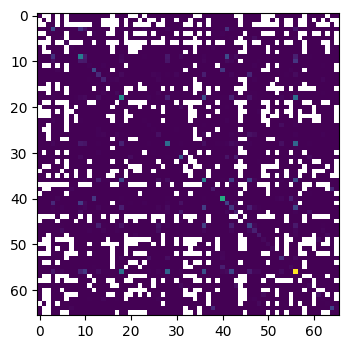

In [13]:
plt.imshow(dtable2)

In [14]:
def fake_len(x):
    #print coredf.ix[x.index[0]]
    #raise Exception
    return tuple(x)

In [15]:
dtable3 = pd.pivot_table(coredf, index=['start_district_hash'], 
                        columns=['dest_district_hash'], aggfunc=[fake_len],
                       values=['expected_travel_time']).as_matrix()

In [16]:
C = 1 / float(len(coredf))

In [17]:
def loss(x):
    
    l = 0
    lprime = np.zeros(len(x), dtype=np.float64)
    
    for i in range(N):
        xi = x[2 * i]
        yi = x[2 * i + 1]
        for j in range(N):
            xj = x[2 * j] 
            yj = x[2 * j + 1]
            if dtable3[i][j]:
                #for dijk in dtable3[i][j]:
                    dijk = np.array(dtable3[i][j])
                    squaredDistance = (xj - xi) * (xj - xi) + (yj - yi) * (yj - yi)
                    distance = np.sqrt(squaredDistance)
                    delta = squaredDistance - dijk * dijk
                
                    l += (delta * delta).sum() * C
                
                    lprime[2*i]     += 4 * delta.sum() * (xi - xj) * C
                    lprime[2*i + 1] += 4 * delta.sum() * (yi - yj) * C

                    lprime[2*j]     += 4 * delta.sum() * (xj - xi) * C
                    lprime[2*j + 1] += 4 * delta.sum() * (yj - yi) * C
    print l
    
    return (l, lprime)

In [18]:
x = np.zeros(len(dtable.index)*2, dtype=np.float64)

for i in range(N):
    x[2*i:2*i+2,] = pos[i,:]

In [19]:
loss(x)

70947.4680937


(70947.468093730291,
 array([  6.03138535e+00,   1.92204986e+00,  -4.19075080e+00,
         -3.05899236e+00,  -3.73067372e+00,  -3.95850455e+00,
          3.34679116e+01,   2.77710565e+01,   9.53388724e-01,
         -4.11805303e+00,   1.29919916e+01,  -8.65201665e+00,
         -3.03268399e+02,  -2.92501967e+01,   2.48768164e+01,
         -1.72126044e+01,   1.00701642e+01,   1.06094099e+00,
          2.89111668e+02,   8.11891677e+01,  -2.62564546e+01,
          1.92786189e+01,   1.12327581e+01,  -1.66255318e+00,
          6.49206541e+00,   7.80954559e+00,  -7.94141560e+01,
         -7.85754634e+01,   9.39733612e+00,  -1.36391640e+01,
          1.39165224e+01,   9.51899803e-01,  -2.02480232e-01,
          4.48312330e+00,   8.32966651e+00,  -5.92103951e+00,
         -7.46812672e+01,  -2.53324585e+01,   7.69005039e+00,
         -5.33242237e+00,  -3.39399332e+00,  -3.66581283e+00,
         -4.73927551e+00,   5.51800591e+00,   2.07947698e+00,
          4.24505072e+00,   3.08993167e+00,   3.7

In [20]:
res = minimize(loss, x, method='CG', jac=True)

70947.4680937
70947.4680937
650909486.211
505614.49259
67124.4731729
64568.4895118
64170.8812406
60495.7650666
60101.0378853
58331.9498733
58589.6051065
57253.3033742
57214.6310303
56663.4722734
56557.6933968
56347.6148851
56243.95695
56160.5281335
56049.6498916
56027.4144345
55852.7747677
55816.2381189
55755.4970205
55687.0373098
55613.1807173
55527.3903142
55472.8789058
55835.7497981
55465.7408373
55452.8000442
55431.1182958
55408.9992353
55390.1830339
55356.3056466
55304.3598725
55406.960242
55277.6308942
55239.9909227
55227.9042035
55217.4940463
55208.7057596
55203.4778719
55179.3095218
55155.4529518
55089.61043
55113.0264103
55061.6467443
55035.1143528
55003.6160805
54981.3726732
54980.6567201
54969.833335
54952.6746426
54947.9523586
54964.7628791
54939.8688493
54931.8021407
54925.1505665
54913.6050894
54900.9761023
54882.5502812
54870.4982645
54850.5622624
54837.524203
54805.3315685
54782.5305008
54796.2519866
54773.5233879
54762.421107
54768.611329
54758.0250931
54758.1881359
54

In [21]:
pos2 = np.zeros(pos.shape,dtype=np.float64)

In [22]:
for i in range(N):
    pos2[i,:] = res.x[2*i:2*i+2,]

In [23]:
posdf = pd.DataFrame(pos2, columns=['x','y'], index = dtable2.index)

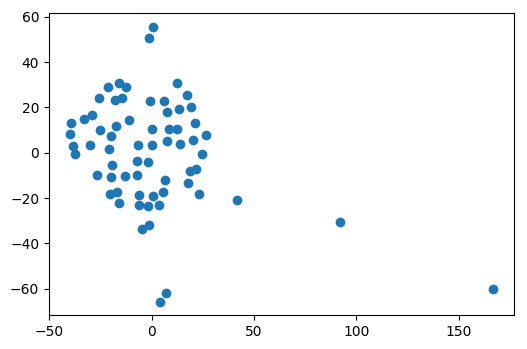

In [24]:
plt.scatter(pos2[:,0],pos2[:,1])

In [25]:
posdf.to_csv('inferred_locations.csv')

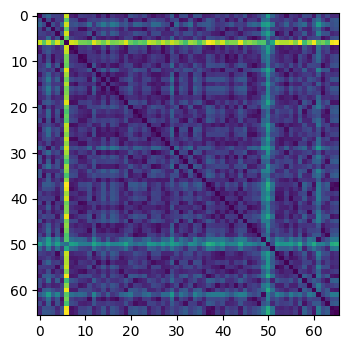

In [26]:
D2 = squareform(pdist(pos2))
plt.imshow(D2)

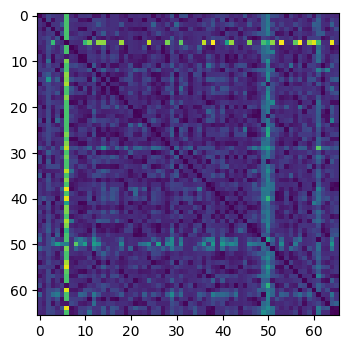

In [27]:
plt.imshow(dtable.as_matrix())

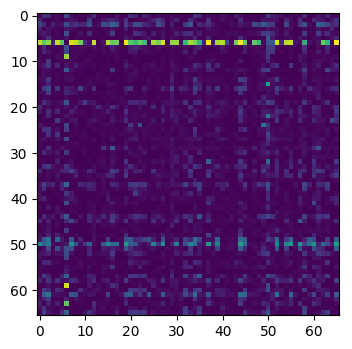

In [28]:
plt.imshow(np.abs(dtable.as_matrix() - D2));

In [29]:
np.nan_to_num(np.abs(dtable.as_matrix() - D2)).mean()

9.3401062063794562

This finishes the show!

In [30]:
D2.mean()

42.2683421733336

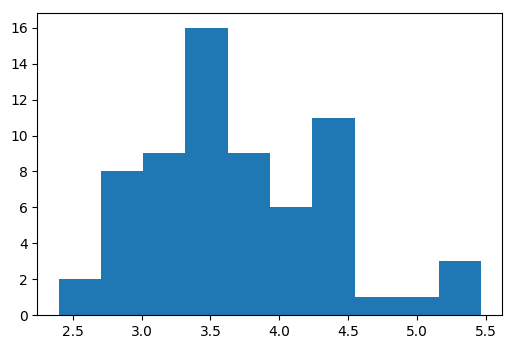

In [31]:
plt.hist(np.diag(dtable));

In [32]:
orderdf['expected_travel_time'].mean()

8.079615916294097

In [33]:
posdf

,x,y
start_district_hash,,
08232402614a9b48895cc3d0aeb0e9f2,-26.581013,-9.949639
08f5b445ec6b29deba62e6fd8b0325a6,21.345505,13.128810
0a5fef95db34383403d11cb6af937309,0.930763,55.392778
1afd7afbc81ecc1b13886a569d869e8a,13.747900,3.996580
1c60154546102e6525f68cb4f31e0657,-15.647777,30.545809
1cbfbdd079ef93e74405c53fcfff8567,5.448162,-17.451462
1ecbb52d73c522f184a6fc53128b1ea1,166.529633,-60.058533
2301bc920194c95cf0c7486e5675243c,-25.245040,9.985234
2350be163432e42270d2670cb3c02f80,-20.636767,1.550406


NameError: name 'dtable' is not defined